In [3]:
using Zygote
using CuArrays
using CUDAnative
using CUDAdrv
using NNlib
using Test
using BenchmarkTools
using Flux
using Plots
using Images
using Colors
using ProgressMeter
using StaticArrays
using Statistics

In [4]:
#Zygote.@adjoint gpu(a :: Array) = gpu(a), a̅ -> (cpu(a̅),)
Zygote.@adjoint function Base.convert(::Type{T}, xs::Array{K,N}) where {T<:CuArray, K, N}
  Base.convert(T, xs), Δ -> (nothing, Base.convert(Array, Δ),)
end
Zygote.refresh()

# quantization

In [5]:
CuArrays.allowscalar(false)

### weights

In [6]:
function weight_masks(W, us)
    dims = size(W)

    W̅ = W .- mean(W)

    std_W = std(W)

    W̃s = cat((sign.(W̅ .+ (u * std_W)) for u in us)...,
            dims=length(size(W)) + 1)

    W̃s
end

weight_masks (generic function with 1 method)

In [7]:
function binarize_weights(W, us)
    W̃s = weight_masks(W, us)

    dims = size(W)

    Wv = reshape(W, :)
    W̃vs = reshape(W̃s, :, length(us))

    αs = W̃vs \ Wv

    W̃v = W̃vs * αs
    
    W̃ = reshape(W̃v, dims...)

    W̃, αs
end

binarize_weights (generic function with 1 method)

In [9]:
Zygote.@adjoint function binarize_weights(W, us) 
    W̃ = binarize_weights(W, us)
    function adjoint((∇_W̃, ∇_αs)) 
        # the "straight-through estimator"
        (∇_W̃, nothing)
    end
    W̃, adjoint
end
Zygote.refresh()

In [10]:
even_us(M) = if M == 1
        [0.0f0]
    else
        Array(range(-1.0f0, stop=1.0f0, length=M))
end
function even_err(M, W)
    us = even_us(M)
    W̃, _ = binarize_weights(W, us)
    mean((W .- W̃).^2)
end

even_err (generic function with 1 method)

In [11]:
W = randn(Float32, 3,3,10,10)
()

()

In [12]:
binarize_weights(W, even_us(3))
()

()

In [13]:
# todo write gradient test!

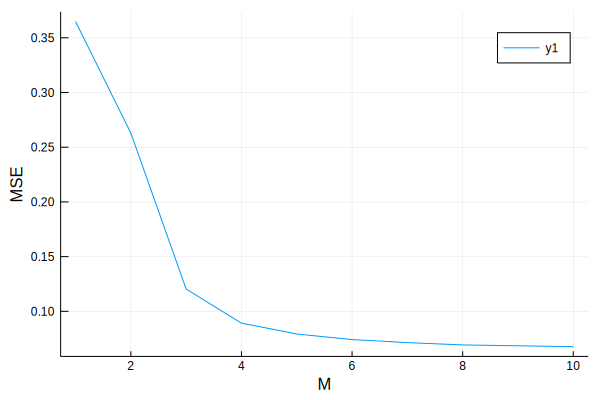

In [14]:
Ms = 1:10
errs = [even_err(M, W) for M in Ms]
plot(Ms, errs, xlabel="M", ylabel="MSE")

In [13]:
# don't solve for alphas
function binarize_weights(W, us, αs)
    W̃s = weight_masks(W, us)

    dims = size(W)

    Wv = reshape(W, :)
    W̃vs = reshape(W̃s, :, length(us))

    W̃v = W̃vs * αs
    
    W̃ = reshape(W̃v, dims...)

    W̃
end

Zygote.@adjoint function binarize_weights(W, us, αs)
    # not sure why you'd need this, but might as well...
    W̃ = binarize_weights(W, us, αs)
    function adjoint(∇_W̃) 
        # the "straight-through estimator"
        (∇_W̃, nothing, nothing)
    end
    W̃, adjoint
end
Zygote.refresh()

In [14]:
us = even_us(5)
W̃, αs = binarize_weights(W, us)
W̃1 = binarize_weights(W, us, αs)

@test W̃ == W̃1

Test Passed

In [15]:
∇_W, ∇_us, ∇_αs = Zygote.gradient((W, us, αs) -> sum(binarize_weights(W, us, αs)), W, us, αs)
@test ∇_W == ones(Float32, size(W))
@test ∇_us == nothing
@test ∇_αs == nothing

Test Passed

In [329]:
function binarize_weights(W :: CuArray, us)
    W̃, αs = binarize_weights(cpu(W), cpu(us))
    gpu(W̃), gpu(αs)
end
function binarize_weights(W :: CuArray, us, αs)
    W̃ = binarize_weights(cpu(W), cpu(us), cpu(αs))
    gpu(W̃)
end

binarize_weights (generic function with 4 methods)

In [330]:
@btime binarize_weights(W, even_us(5))
()

  87.720 μs (201 allocations: 109.77 KiB)


()

In [12]:
Wg = gpu(W)
@btime binarize_weights(Wg, even_us(5))
()

  166.781 μs (241 allocations: 119.70 KiB)


()

### activations

In [154]:
function z(q)
    if q > 0.5f0
        1.0f0
    else
        -1.0f0
    end
end

function _zrev(q, ∇_q)
    if 0.0f0 < q < 1.0f0
        ∇_q
    else
        0.0f0
    end
end

Zygote.@adjoint z(q) = z(q), (∇_q) -> _zrev(q, ∇_q)

function zb(Q)
    z.(Q)
end

Zygote.@adjoint zb(Q) = zb(Q), (∇_Q) -> (_zrev.(Q, ∇_Q),)

Zygote.refresh()

In [155]:
function binarize_activations(A, vs, βs)
    shape = size(A)
    
    Av_x = reshape( (A), :, 1)
    
    vs_x = reshape( (vs), 1, :)
    βs_x = reshape( (βs), 1, :)
    
    Av1 =  (Av_x) .+  (vs_x)
    #Av2 = z.( (Av1))
    Av2 = zb( (Av1))
    Av3 =  (Av2) .*  (βs_x)
    
    Ãv = sum( (Av3), dims=2)
    
    result = reshape( (Ãv), shape)
        
    result
end

Zygote.refresh()


In [156]:
A = randn(Float32, 4, 4)

4×4 Array{Float32,2}:
 -0.87212    0.161947   -0.952302  -0.892614
  0.614873  -0.446069    0.704746  -0.592104
  1.30157    0.0858498  -0.155583   1.98845 
  0.334237  -0.444257   -1.54135   -0.413687

In [157]:
vs = even_us(2)
bs = βs = ones(Float32, 2)

binarize_activations(A, vs, bs)

4×4 Array{Float32,2}:
 -2.0  0.0  -2.0  -2.0
  0.0  0.0   0.0  -2.0
  0.0  0.0   0.0   2.0
  0.0  0.0  -2.0   0.0

In [158]:
Zygote.gradient((A, vs, βs) -> sum(binarize_activations(A, vs, βs)), A, vs, bs)

(Float32[1.0 0.0 1.0 1.0; 0.0 1.0 0.0 1.0; 1.0 0.0 1.0 1.0; 0.0 1.0 0.0 1.0], Float32[2.0, 8.0], Float32[-14.0, 6.0])

In [24]:
binarize_activations(gpu(A), gpu(even_us(2)), gpu(ones(2)))

4×4 CuArray{Float32,2,CuArray{Float32,2,Nothing}}:
 0.0  -2.0   0.0  -2.0
 0.0  -2.0   0.0  -2.0
 0.0   0.0  -2.0   0.0
 0.0  -2.0   0.0   0.0

In [25]:
((A, vs, βs) -> sum(binarize_activations(A, vs, βs)))(gpu(A), gpu(even_us(2)), gpu(ones(2)))

-12.0f0

In [26]:
Zygote.gradient((A, vs, βs) -> sum(binarize_activations(A, vs, βs)), gpu(A), gpu(even_us(2)), gpu(ones(2)))

(Float32[0.0 1.0 0.0 1.0; 0.0 1.0 1.0 0.0; 0.0 0.0 1.0 1.0; 0.0 0.0 0.0 1.0], Float32[0.0, 7.0], Float32[-16.0, 4.0])

In [27]:
function normal_error_plot(N, steps=1000)
    vs = gpu(even_us(2))
    bs = βs = gpu(ones(Float32, 2))

    opt = ADAM()
    ps = Params([vs, βs])
    errors = Float32[]
    @showprogress for _ in 1:steps
        # note: in loop!
        A = gpu(randn(100, 100))
        err, adjoint = pullback(ps) do
            Ã = binarize_activations(A, vs, βs)
            mean((A .- Ã).^2)
        end
        gs = adjoint(1.0)

        Flux.Optimise.update!(opt, ps, gs)
        push!(errors, err)
    end
    plot(errors, xlabel="gradient descent step", ylabel="MSE", title="error with N=$N bits")
end

normal_error_plot (generic function with 2 methods)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


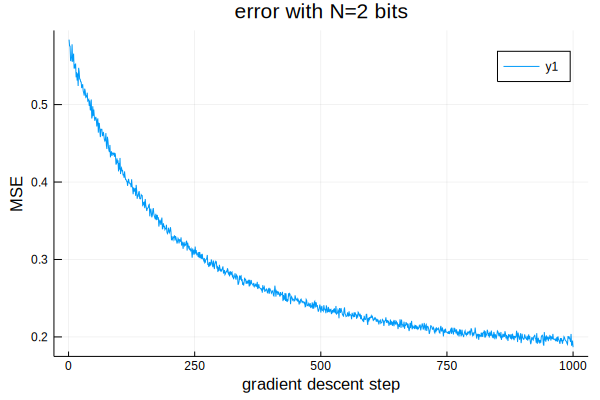

In [28]:
normal_error_plot(2)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


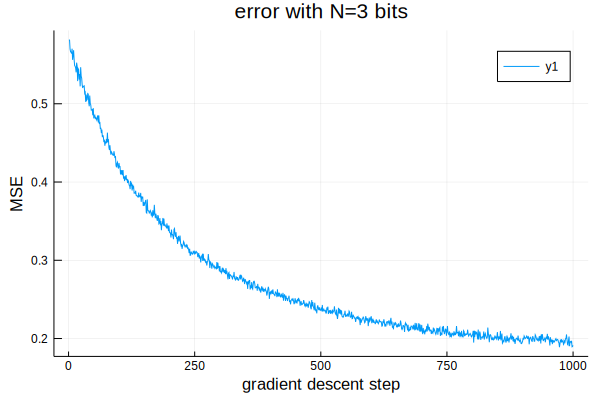

In [29]:
normal_error_plot(3)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


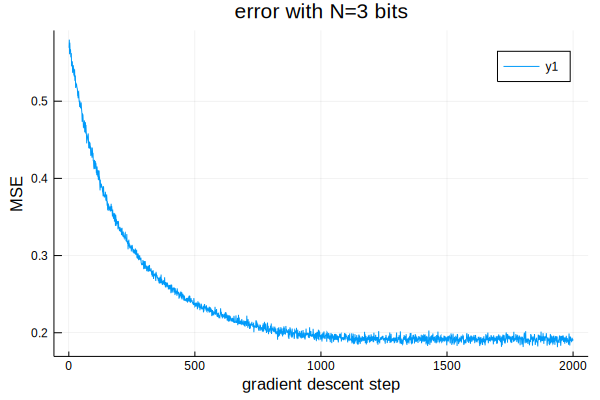

In [30]:
normal_error_plot(3, 2000)

In [31]:
# todo: should we use those learned weights as initializers? they approximate the normal distribution.

function normal_approximators(N)
    vs = gpu(even_us(N))
    βs = gpu(ones(Float32, N))

    opt = ADAM()
    ps = Params([vs, βs])

    for _ in 1:1000
        # note: in loop!
        A = gpu(randn(100, 100))
        _, adjoint = pullback(ps) do
            Ã = binarize_activations(A, vs, βs)
            mean((A .- Ã).^2)
        end
        gs = adjoint(1.0)

        Flux.Optimise.update!(opt, ps, gs)
    end
    
    vs, βs
end

normal_approximators(2)

(Float32[-0.263087, 1.05853], Float32[0.591713, 0.669902])

In [32]:
normal_approximators(2)

(Float32[-0.262703, 1.05827], Float32[0.591643, 0.672335])

In [33]:
normal_approximators(3)

(Float32[-0.535493, 0.420531, 1.40799], Float32[0.514053, 0.496134, 0.562909])

# layers

In [21]:
mutable struct BinWeights{U <: AbstractVector, A <: AbstractVector}
    us :: U
    αs :: A
    active :: Bool
end

function BinWeights(W, us :: U; active=false) where U
    # note: W is not stored! it's just used to initialize alphas.
    _, αs = binarize_weights(W, us)
    BinWeights(us, αs, active)
end

BinWeights

In [22]:
# note: no args, because the parameters aren't trainable, and shouldn't be moved to GPU.
Flux.@functor BinWeights ()

In [159]:
function (bw :: BinWeights{U, A})(W) where {U, A}
    if bw.active
        if Flux.istraining()
            W̃, αs = binarize_weights(W, bw.us)
            bw.αs = αs
            W̃
        else
            # todo: cache W̃?
            W̃ = binarize_weights(W, bw.us, bw.αs)
            W̃
        end
    else
        W
    end
end

In [160]:
q = BinWeights(W, even_us(5), active=true)

BinWeights{Array{Float32,1},Array{Float32,1}}(Float32[-1.0, -0.5, 0.0, 0.5, 1.0], Float32[0.365286, 0.241805, 0.234198, 0.242631, 0.379702], true)

In [161]:
@test q(W) == binarize_weights(W, even_us(5))[1]

Test Passed

In [162]:
@test gpu(q) === q

Test Passed

In [163]:
mutable struct BinActs{V, B}
    vs :: V
    βs :: B
    active :: Bool
end

function BinActs(vs :: V, βs :: B; active=false) where {V, B}
    # note: W is not stored! it's just used to initialize alphas.
    BinActs(vs, βs, active)
end

function (ba :: BinActs{V, B})(A) where {V, B}
    if ba.active
        binarize_activations(A, ba.vs, ba.βs)
    else
        A
    end
end

Flux.@functor BinActs (vs, βs)

In [164]:
# from https://github.com/FluxML/Flux.jl/blob/fb4a48f970ba40d0022a7488b48d19cd563867c4/src/layers/conv.jl
# note: does not include activation, that should go before (?)

"""
Standard convolutional layer with ABC-based quantization.
"""
struct ABCConv{W,Z, S,P, U,A, V,B} # that's a lotta parameters!!
    weight::W
    bias::Z
    
    stride::NTuple{S,Int}
    pad::NTuple{P,Int}
    dilation::NTuple{S,Int}
    
    bin_weights :: BinWeights{U, A}
    bin_acts :: BinActs{V, B}
end

ABCConv

In [337]:
function ABCConv(weight::AbstractArray{T,K}, bias::AbstractVector{T},
                 us::AbstractVector{T}, vs::AbstractVector{T}, βs::AbstractVector{T};
              stride = 1, pad = 0, dilation = 1, bin_active=false) where {T, K}
    @assert size(vs) == size(βs)
    
    stride = expand(Val(K-2), stride)
    pad = expand(Val(2*(K-2)), pad)
    dilation = expand(Val(K-2), dilation)
    
    bin_weights = BinWeights(weight, us, active=bin_active) # note: weights is used to initialize αs, not stored
    bin_acts = BinActs(vs, βs, active=bin_active)
    
    ABCConv(weight, bias, stride, pad, dilation, bin_weights, bin_acts)
end

expand(N, i::Tuple) = i
expand(N, i::Integer) = ntuple(_ -> i, N)

function ABCConv(k::NTuple{D,Integer}, ch::Pair{<:Integer,<:Integer}, N::Integer, M::Integer;
    weight_init = Flux.glorot_uniform, bias_init=k -> zeros(Float32, k), 
    us_init=even_us, vs_init=even_us, βs_init=k -> ones(Float32, k), 
    stride = 1, pad = 0, dilation = 1,
    bin_active=false) where D
        
    ABCConv(weight_init(k..., ch...), bias_init(ch[2]),
           us_init(M), vs_init(N), βs_init(N),
           stride = stride, pad = pad, dilation = dilation, bin_active=bin_active)
end

Flux.@functor ABCConv

function (c::ABCConv)(A::AbstractArray)
    b = reshape(c.bias, map(_->1, c.stride)..., :, 1)
    
    W = c.weight
    W̃ = c.bin_weights(W)
    
    Ã = c.bin_acts(A)
    
    cdims = DenseConvDims(Ã, W̃; stride=c.stride, padding=c.pad, dilation=c.dilation)
    #println("W̃: ", typeof(W̃), " ", size(W̃), " Ã: ", typeof(Ã), " ", size(Ã), " b: ", typeof(b), " ", size(b), " dims: ", cdims)
    
    conv(Ã, W̃, cdims) .+ b
end

# Base.show(io :: IO, ::Type{ABCConv}) = print(io, "ABCConv")
function Base.show(io::IO, l::ABCConv)
    print(io, "ABCConv(", size(l.weight)[1:ndims(l.weight)-2])
    print(io, ", ", size(l.weight, ndims(l.weight)-1), "=>", size(l.weight, ndims(l.weight)))
    print(io, ", ", size(l.bin_acts.vs), ", ", size(l.bin_weights.us))
    print(io, ", active=", l.bin_acts.active)

    print(io, ")")
end

In [265]:
function (c::Conv)(A::AbstractArray)

  σ, b = c.σ, reshape(c.bias, map(_->1, c.stride)..., :, 1)
  W = c.weight
  cdims = DenseConvDims(A, W; stride=c.stride, padding=c.pad, dilation=c.dilation)

  r = σ.(conv(A, W, cdims) .+ b)

  r
end

In [332]:
Conv((3, 3), 10=>10)(randn(Float32, 5, 5, 10, 1))
ABCConv((3, 3), 10=>10, 1, 1, bin_active=true)(randn(Float32, 5, 5, 10, 1))
()

W̃: Array{Float32,4} (3, 3, 10, 10) Ã: Array{Float32,4} (5, 5, 10, 1) b: Array{Float32,4} (1, 1, 10, 1) dims: DenseConvDims: (5, 5, 10) * (3, 3) -> (3, 3, 10), stride: (1, 1) pad: (0, 0, 0, 0), dil: (1, 1), flip: false


()

In [333]:
gpu(Conv((3, 3), 10=>10))(gpu(randn(Float32, 5, 5, 10, 1)))
gpu(ABCConv((3, 3), 10=>10, 1, 1, bin_active=true))(gpu(randn(Float32, 5, 5, 10, 1)))

()

W̃: CuArray{Float32,4,Nothing} (3, 3, 10, 10) Ã: CuArray{Float32,4,Nothing} (5, 5, 10, 1) b: CuArray{Float32,4,CuArray{Float32,1,Nothing}} (1, 1, 10, 1) dims: DenseConvDims: (5, 5, 10) * (3, 3) -> (3, 3, 10), stride: (1, 1) pad: (0, 0, 0, 0), dil: (1, 1), flip: false


()

In [285]:
Zygote.refresh()

In [286]:
q = ABCConv((3,3), 10 => 10, 1, 1)

In [194]:
function binarize(c :: ABCConv; active=true)
    c.bin_acts.active = active
    c.bin_weights.active = active
    ()
end

binarize (generic function with 1 method)

# MNIST

In [49]:
# Based on Flux MNIST example

using Flux, Statistics
using Flux: onehotbatch, onecold, crossentropy, throttle
using Base.Iterators: repeated, partition
using Printf, BSON

dataset = Flux.Data.FashionMNIST

@info("Loading data set")
train_labels = dataset.labels()
train_imgs = dataset.images()
()

┌ Info: Loading data set
└ @ Main In[49]:10


()

In [338]:
Zygote.refresh()

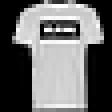

In [50]:
Gray.(train_imgs[2])

In [68]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

batch_size = 128
mb_idxs = partition(1:length(train_imgs), batch_size)
train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs]

test_imgs = dataset.images(:test)
test_labels = dataset.labels(:test)
mb_idxs = partition(1:length(test_imgs), batch_size)
test_set = [make_minibatch(test_imgs, test_labels, i) for i in mb_idxs]

train_set = gpu.(train_set)
test_set = gpu.(test_set)
()

()

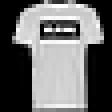

In [71]:
Gray.(cpu(train_set[1])[1][:,:,1,2])

In [74]:
Gray.(cpu(train_set[1])[2][:,:])

In [75]:
struct Relu
end

(r :: Relu)(x) = relu.(x)

Flux.@functor Relu

In [339]:
N = 3
M = 3

@info("Constructing model...")
model = Chain(
    Conv((3, 3), 1=>16, pad=(1,1)),
    
    BatchNorm(16),
    Relu(),
    ABCConv((3, 3), 16=>32, N, M, pad=(1,1)),
    
    BatchNorm(32),
    Relu(),
    ABCConv((3, 3), 32=>32, N, M, pad=(1,1)),
    
    MaxPool((2,2)),
    
    BatchNorm(32),
    Relu(),
    ABCConv((3, 3), 32=>32, N, M, pad=(1,1)),
    
    BatchNorm(32),
    Relu(),
    ABCConv((3, 3), 32=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCConv((3, 3), 64=>64, N, M, pad=(1,1)),
    
    MaxPool((2,2)),

    BatchNorm(64),
    Relu(),
    ABCConv((3, 3), 64=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCConv((3, 3), 64=>64, N, M, pad=(1,1)),
    
    BatchNorm(64),
    Relu(),
    ABCConv((3, 3), 64=>64, N, M, pad=(1,1)),
    
    MaxPool((2,2)),

    x -> reshape(x, :, size(x, 4)),
    
    Relu(),
    Dense(64 * 3 * 3, 10),

    softmax,
)
model = gpu(model)

┌ Info: Constructing model...
└ @ Main In[339]:4


Chain(Conv((3, 3), 1=>16), BatchNorm(16), Relu(), ABCConv((3, 3), 16=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCConv((3, 3), 32=>32, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(32), Relu(), ABCConv((3, 3), 32=>32, (3,), (3,), active=false), BatchNorm(32), Relu(), ABCConv((3, 3), 32=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCConv((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), BatchNorm(64), Relu(), ABCConv((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCConv((3, 3), 64=>64, (3,), (3,), active=false), BatchNorm(64), Relu(), ABCConv((3, 3), 64=>64, (3,), (3,), active=false), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), getfield(Main, Symbol("##575#576"))(), Relu(), Dense(576, 10), NNlib.softmax)

In [340]:
function loss(x, y)
    ŷ = model(x)
    return crossentropy(ŷ, y)
end

loss (generic function with 1 method)

In [ ]:
# Make sure our model + gradients are nicely precompiled before starting our training loop
model(train_set[1][1])
_ = gradient(Flux.params(model)) do
    loss(train_set[1]...)
end
()

In [309]:
opt = ADAM(0.001)

ADAM(0.001, (0.9, 0.999), IdDict{Any,Any}())

In [310]:
# https://github.com/FluxML/Flux.jl/blob/bdeb9c6d584668c7cef1ce71caf659d611c86d65/src/optimise/train.jl

In [311]:
"""
    train!(loss, params, data, opt; cb)
For each datapoint `d` in `data` computes the gradient of `loss(d...)` through
backpropagation and calls the optimizer `opt`.
Takes a callback as keyword argument `cb`. For example, this will print "training"
every 10 seconds:
```julia
Flux.train!(loss, params, data, opt,
            cb = throttle(() -> println("training"), 10))
```
The callback can call `Flux.stop()` to interrupt the training loop.
Multiple optimisers and callbacks can be passed to `opt` and `cb` as arrays.
"""
function train!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  cb = Flux.Optimise.runall(cb)
  @showprogress for d in data
    try
      gs = gradient(ps) do
        loss(d...)
      end
      Flux.Optimise.update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa Flux.Optimise.StopException
        break
      else
        rethrow(ex)
      end
    end
  end
end

train!

In [312]:
onecold_(y::AbstractMatrix, labels...) =
  dropdims(mapslices(y -> Base.argmax(y, labels...), y, dims=1), dims=1)

function evaluate(model, data)
    correct = 0.0
    total = 0.0
    for d in data
        ŷ = cpu(model(d[1])) # reduction on GPU recompiles every iteration ???
        ŷ_cold = onecold_(ŷ)
        y = cpu(d[2])
        y_cold = onecold_(y)
        diff = y_cold .== ŷ_cold
        correct += sum(diff)
        total += size(d[2])[2]
    end
    return correct / total
end

evaluate (generic function with 1 method)

In [313]:
@info("Beginning training loop...")

best_acc = 0.0
last_improvement = 0

for epoch_idx in 1:5
    global best_acc, last_improvement
    # Train for a single epoch
    train!(loss, Flux.params(model), train_set, opt)

    # Calculate accuracy:
    acc = evaluate(model, test_set)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to data/mnist_conv.bson")
        BSON.@save joinpath(dirname(@__FILE__), "data/mnist_conv.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: Beginning training loop...
└ @ Main In[313]:1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: [1]: Test accuracy: 0.8751
└ @ Main In[313]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[313]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
┌ Info: [2]: Test accuracy: 0.8985
└ @ Main In[313]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[313]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: [3]: Test accuracy: 0.9042
└ @ Main In[313]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[313]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16
┌ Info: [4]: Test accuracy: 0.9120
└ @ Main In[313]:13
┌ Info:  -> New best accuracy! Saving model out to data/mnist_conv.bson
└ @ Main In[313]:23
Progress: 100%|█████████████████████████████████████████| Time: 0:00:1

In [319]:
isa(model.layers[4], ABCConv)

true

In [320]:
for layer in model.layers
    if isa(layer, ABCConv)
        binarize(layer)
    end
end
acc = evaluate(model, test_set)
@info(@sprintf("Post-quantization test accuracy: %.4f", acc))


ArgumentError: ArgumentError: cannot take the CPU address of a CuArray{Float32,2,CuArray{Float32,5,Nothing}}

In [305]:
@info("quantizing...")

for epoch_idx in 1:5
    global best_acc, last_improvement
    # Train for a single epoch
    train!(loss, Flux.params(model), train_set, opt)

    # Calculate accuracy:
    acc = evaluate(model, test_set)
    @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))

    # If our accuracy is good enough, quit out.
    if acc >= 0.999
        @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
        break
    end

    # If this is the best accuracy we've seen so far, save the model out
    if acc >= best_acc
        @info(" -> New best accuracy! Saving model out to data/mnist_conv.bson")
        BSON.@save joinpath(dirname(@__FILE__), "data/mnist_conv.bson") model epoch_idx acc
        best_acc = acc
        last_improvement = epoch_idx
    end

    # If we haven't seen improvement in 5 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
        opt.eta /= 10.0
        @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end

    if epoch_idx - last_improvement >= 10
        @warn(" -> We're calling this converged.")
        break
    end
end

┌ Info: quantizing...
└ @ Main In[305]:1
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18
┌ Info: [1]: Test accuracy: 0.9024
└ @ Main In[305]:10
Progress:  12%|█████                                    |  ETA: 0:00:13

InterruptException: InterruptException:

1

# reflection

In [270]:
function fieldmeta(q)
    println(typeof(q))
    for name in fieldnames(typeof(q))
        field = getfield(q, name)
        shape = if typeof(field) <: AbstractArray
            repr(size(field))
        else
            ""
        end
        
        println('\t', String(name), '\t', typeof(field), '\t', shape)
    end
end

fieldmeta (generic function with 1 method)

# cuda stuff

In [37]:
N = 2^20
x = fill(1.0f0, N)  # a vector filled with 1.0 (Float32)
y = fill(2.0f0, N)  # a vector filled with 2.0

y .+= x             # increment each element of y with the corresponding element of x

1048576-element Array{Float32,1}:
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 ⋮  
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0
 3.0

In [39]:
@test all(y .== 3.0f0)

Test Passed

In [40]:
function sequential_add!(y, x)
    for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
sequential_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [41]:
function parallel_add!(y, x)
    Threads.@threads for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
parallel_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [44]:
@btime sequential_add!($y, $x)

  321.687 μs (0 allocations: 0 bytes)


In [45]:
@btime sequential_add!($y, $x)

  326.044 μs (0 allocations: 0 bytes)


In [46]:
x_d = CuArrays.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CuArrays.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0

1048576-element CuArray{Float32,1,Nothing}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮  
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [47]:
y_d .+= x_d
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [48]:
function add_broadcast!(y, x)
    CuArrays.@sync y .+= x
    return
end

@btime add_broadcast!(y_d, x_d)

  58.964 μs (63 allocations: 2.67 KiB)


In [49]:
using CUDAnative

function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [50]:
function bench_gpu1!(y, x)
    CuArrays.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

@btime bench_gpu1!(y_d, x_d)

  149.128 ms (25 allocations: 736 bytes)


In [51]:
using CUDAdrv
bench_gpu1!(y_d, x_d)  # run it once to force compilation
CUDAdrv.@profile bench_gpu1!(y_d, x_d)

┌ Warning: Calling CUDAdrv.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler like `nvprof`.
│ 
│ For improved usability, launch Julia under the Nsight Systems profiler:
│ $ nsys launch -t cuda,cublas,cudnn,nvtx julia
└ @ CUDAdrv.Profile /data/scratch/jhgilles/.julia/packages/CUDAdrv/3EzC1/src/profile.jl:42


In [52]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [53]:
function bench_gpu2!(y, x)
    CuArrays.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

@btime bench_gpu2!(y_d, x_d)

  1.308 ms (25 allocations: 736 bytes)


In [54]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

numblocks = ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=256 blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [55]:
function bench_gpu3!(y, x)
    numblocks = ceil(Int, length(y)/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

@btime bench_gpu3!(y_d, x_d)

  57.996 μs (28 allocations: 784 bytes)


In [56]:
function gpu_add2_print!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    @cuprintf("threadIdx %ld, blockDim %ld\n", index, stride)
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

@cuda threads=16 gpu_add2_print!(y_d, x_d)
synchronize()

threadIdx 1, blockDim 16
threadIdx 2, blockDim 16
threadIdx 3, blockDim 16
threadIdx 4, blockDim 16
threadIdx 5, blockDim 16
threadIdx 6, blockDim 16
threadIdx 7, blockDim 16
threadIdx 8, blockDim 16
threadIdx 9, blockDim 16
threadIdx 10, blockDim 16
threadIdx 11, blockDim 16
threadIdx 12, blockDim 16
threadIdx 13, blockDim 16
threadIdx 14, blockDim 16
threadIdx 15, blockDim 16
threadIdx 16, blockDim 16
